In [461]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns 

from darts import TimeSeries

## Data Preprocessing - Store Sales

### train.csv and test.csv

In [462]:
# Loading Data
train = pd.read_csv("Data/train.zip", parse_dates=["date"])
test = pd.read_csv("Data/test.csv", parse_dates=["date"])
test_ids = test["id"]

train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [463]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [464]:
family_list = train["family"].unique()
stores_list = train["store_nbr"].unique()

train_start = train["date"].min()
train_end = train["date"].max()
num_period_days_train = (train_end - train_start).days + 1
num_train_days = train["date"].nunique()

test_start = test["date"].min().date()
test_end = test["date"].max().date()
num_period_days_test = (test_end - test_start).days + 1
num_test_days = test["date"].nunique()

print(f"Number of families: {len(family_list)}")
print(f"Number of stores: {len(stores_list)}\n")
print(f"Train period: {train_start.date()} to {train_end.date()} - {num_period_days_train} days")
print(f"Number of train days: {num_train_days}\n")
print(f"Test period: {test_start} to {test_end} - {num_period_days_test} days")
print(f"Number of test days: {num_test_days}")

Number of families: 33
Number of stores: 54

Train period: 2013-01-01 to 2017-08-15 - 1688 days
Number of train days: 1684

Test period: 2017-08-16 to 2017-08-31 - 16 days
Number of test days: 16


In [465]:
# We don't have training data for Christmas days (Store are closed)
missing_train_dates = pd.date_range(train_start, train_end).difference(train["date"].unique())
missing_train_dates = missing_train_dates.strftime('%Y-%m-%d').to_list()

print(f"Missing dates: {', '.join(missing_train_dates)}")

Missing dates: 2013-12-25, 2014-12-25, 2015-12-25, 2016-12-25


In [466]:
# Reindexing train data to have all dates including Christmas days (Closed days with no sales and promotions)
new_idx = pd.MultiIndex.from_product([pd.date_range(train_start, train_end), train["store_nbr"].unique(), train["family"].unique()], names=["date", "store_nbr", "family"])
train = train.set_index(["date", "store_nbr", "family"]).reindex(new_idx).reset_index()
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0)

print(f"Number of missing dates: {train.isnull().sum().sum()}")

Number of missing dates: 0


### store.csv

In [467]:
stores = pd.read_csv("Data/stores.csv")
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [468]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [469]:
num_stores = len(stores["store_nbr"].unique())
num_cities = len(stores["city"].unique())
num_states = len(stores["state"].unique())
num_types = len(stores["type"].unique())

print(f"Number of stores: {num_stores}")
print(f"Number of cities: {num_cities}")
print(f"Number of states: {num_states}")
print(f"Number of types: {num_types}")

Number of stores: 54
Number of cities: 22
Number of states: 16
Number of types: 5


### holiday_events.csv

In [470]:
holidays = pd.read_csv("Data/holidays_events.csv", parse_dates=["date"])
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [471]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [472]:
types = holidays['type'].unique()
locality = holidays['locale'].unique()

print(f"Localities of holidays: {', '.join(locality)}")
print(f"Types of holidays: {', '.join(types)}")

Localities of holidays: Local, Regional, National
Types of holidays: Holiday, Transfer, Additional, Bridge, Work Day, Event


In [473]:
national_locale_name = holidays[holidays["locale"]=="National"]["locale_name"].unique().tolist()
region_locale_name = holidays[holidays["locale"]=="Regional"]["locale_name"].unique().tolist()
local_locale_name = holidays[holidays["locale"]=="Local"]["locale_name"].unique().tolist()

print(f"National holiday places: {', '.join(national_locale_name)}")
print(f"Region holiday places: {', '.join(region_locale_name)}")
print(f"Local holiday places: {', '.join(local_locale_name)}")

National holiday places: Ecuador
Region holiday places: Cotopaxi, Imbabura, Santo Domingo de los Tsachilas, Santa Elena
Local holiday places: Manta, Cuenca, Libertad, Riobamba, Puyo, Guaranda, Latacunga, Machala, Santo Domingo, El Carmen, Cayambe, Esmeraldas, Ambato, Ibarra, Quevedo, Quito, Loja, Salinas, Guayaquil


In [474]:
# Simplifying holiday description
def apply_cleaning(text):
    
    if pd.isna(text): return ""
    text = text.lower()
    
    if "futbol" in text:
        return "futbol"
        
    text = re.sub(loc_pattern, "", text)
    text = re.sub(noise_pattern, "", text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

cities = set(stores['city'].str.lower().unique())
states = set(stores['state'].str.lower().unique())

locations_to_remove = list(cities | states)
loc_pattern = r'\b(' + '|'.join(map(re.escape, locations_to_remove)) + r')\b'

noise_pattern = r'[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b'

holidays["description"] = holidays["description"].apply(apply_cleaning)

holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


In [475]:
# Cleaning transferred holidays
holidays = holidays[holidays["transferred"] == False]

# Getting work days
work_days = holidays[holidays["type"] == "Work Day"]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}).reset_index(drop=True)
work_days["work_day"] = work_days["work_day"].notna().astype(int)
holidays = holidays[holidays["type"] != "Work Day"].reset_index(drop=True)

# Getting local holidays
local_holidays = holidays[holidays["locale"]=="Local"]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "city"}).reset_index(drop=True)
local_holidays = local_holidays.drop_duplicates()
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc", dtype=int)

# Getting regional holidays
regional_holidays = holidays[holidays["locale"] =="Regional"]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "state"}).reset_index(drop=True)
duplicados = regional_holidays[regional_holidays.duplicated(keep=False)]
regional_holidays = pd.get_dummies(regional_holidays, columns=["description"], prefix="reg", dtype=int)

# Getting national holidays
national_holidays = holidays[holidays["locale"] =="National"]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays.drop_duplicates()
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
national_holidays = national_holidays.groupby("date").sum().reset_index()

### oil.csv

In [476]:
oil = pd.read_csv("Data/oil.csv", parse_dates=["date"])
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [477]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [478]:
# We don't have oil price on weekends
missing_oil_dates = pd.date_range(start = oil['date'].min(), end = oil['date'].max()).difference(oil["date"])

print(f"Number of days missing oil price: {len(missing_oil_dates)}")
print(f"Number of weekend days in train data: {(pd.date_range(train_start, test_end).weekday >= 5).sum()}")

Number of days missing oil price: 486
Number of weekend days in train data: 486


In [479]:
# Filling missing values in oil data for weekends and missing values with previous values or next values if not possible
oil["date"] = pd.to_datetime(oil["date"])
oil = oil.set_index("date")

new_idx = pd.date_range(start = oil.index.min(), end = oil.index.max())
oil = oil.reindex(new_idx)

oil = oil.ffill().bfill()

oil = oil.reset_index().rename(columns={"index": "date"})

print(f"Number of missing values in oil data: {oil['dcoilwtico'].isnull().sum()}")

Number of missing values in oil data: 0


### transactions.csv

In [480]:
transactions = pd.read_csv("Data/transactions.csv", parse_dates=["date"])
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [481]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [482]:
num_zero_sales = (train.groupby(["date", "store_nbr"])["sales"].sum() == 0).sum()
total_expected_records = num_stores * num_period_days_train
current_records = len(transactions)

print(f"Expected number of records (Number of Stores * Days): {total_expected_records}\n")
print(f"Number of current records in transactions.csv: {current_records}")
print(f"Number with zero sales: {num_zero_sales}")
print(f"Number with missing sales: {total_expected_records - current_records - num_zero_sales}")

Expected number of records (Number of Stores * Days): 91152

Number of current records in transactions.csv: 83488
Number with zero sales: 7546
Number with missing sales: 118


In [483]:
# Filling missing values in transactions looking if the store is open or not
store_sales = train.groupby(["date", "store_nbr"])["sales"].sum().reset_index()

sales_and_transactions = store_sales.merge(transactions, on=["date", "store_nbr"], how="left")
sales_and_transactions = sales_and_transactions.sort_values(["store_nbr", "date"])

close_mask = (sales_and_transactions["sales"] == 0) & (sales_and_transactions["transactions"].isna())
sales_and_transactions.loc[close_mask, "transactions"] = 0

sales_and_transactions["transactions"] = sales_and_transactions.groupby("store_nbr")["transactions"].transform(
    lambda x: x.interpolate(method="linear", limit_direction="both"))

transactions = sales_and_transactions[["date", "store_nbr", "transactions"]]

print(f"Number of current records after filling missing values: {sales_and_transactions.shape[0]}")

Number of current records after filling missing values: 91152


### Feature Engineering

In [484]:
# Adding day of the week, day, month, year, is weekend, pay day
train['day_of_week'] = train['date'].dt.dayofweek
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)
train['is_payday'] = ((train['day_of_week'] == 15) | (train['date'].dt.is_month_end)).astype(int)

test['day_of_week'] = test['date'].dt.dayofweek
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['is_weekend'] = (test['day_of_week'] >= 5).astype(int)
test['is_payday'] = ((test['day_of_week'] == 15) | (test['date'].dt.is_month_end)).astype(int)

In [485]:
# Creating oil features with moving average and filling first values with previous values
oil["oil_ma7"] = oil["dcoilwtico"].rolling(window=7).mean()
oil["oil_ma30"] = oil["dcoilwtico"].rolling(window=30).mean()

oil["oil_ma7"] = oil["oil_ma7"].bfill()
oil["oil_ma30"] = oil["oil_ma30"].bfill()

In [486]:
# Creating lags for transactions data to use it in prediction for train and test data
new_idx = pd.MultiIndex.from_product([pd.date_range(transactions["date"].min(), test_end), train["store_nbr"].unique()], names=["date", "store_nbr"])
transactions = transactions.set_index(["date", "store_nbr"]).reindex(new_idx).reset_index()

transactions['transactions_lag_16'] = transactions.groupby("store_nbr")["transactions"].shift(16)
transactions['transactions_lag_21'] = transactions.groupby("store_nbr")["transactions"].shift(21)
transactions['transactions_lag_28'] = transactions.groupby("store_nbr")["transactions"].shift(28)
transactions['transactions_lag_30'] = transactions.groupby("store_nbr")["transactions"].shift(30)
transactions['transactions_lag_365'] = transactions.groupby("store_nbr")["transactions"].shift(365)

transactions['transactions_ma7_shift_16'] = transactions.groupby("store_nbr")["transactions"].transform(
    lambda x: x.shift(16).rolling(window=7).mean())
transactions['transactions_ma30_shift_16'] = transactions.groupby("store_nbr")["transactions"].transform(
    lambda x: x.shift(16).rolling(window=30).mean())

In [487]:
# Creating lags for sales data to use it in prediction with the log transformation
train["sales_lg"] = np.log1p(train["sales"])

df_total = pd.concat([train, test], ignore_index=True)
df_total = df_total.sort_values(["store_nbr", "family", "date"])

df_total['sales_lag_16'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(16)
df_total['sales_lag_21'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(21)
df_total['sales_lag_28'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(28)
df_total['sales_lag_30'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(30)
df_total['sales_lag_365'] = df_total.groupby(["store_nbr", "family"])["sales_lg"].shift(365)

df_total["sales_ma7_shift16"] = df_total.groupby(["store_nbr", "family"])["sales_lg"].transform(
        lambda x: x.shift(16).rolling(window=7).mean())
df_total["sales_ma30_shift16"] = df_total.groupby(["store_nbr", "family"])["sales_lg"].transform(
        lambda x: x.shift(16).rolling(window=30).mean())

In [488]:
# Dividing data into train and test again and cleaning them
train = df_total[df_total["date"] <= train_end].copy()
test = df_total[df_total["date"] > train_end].copy()

In [489]:
# Merging stores data with train and test datasets
train = train.merge(stores, on="store_nbr", how="left")
test = test.merge(stores, on="store_nbr", how="left")

# Merging oil data with train and test datasets
train = train.merge(oil, on="date", how="left")
test = test.merge(oil, on="date", how="left")

# Merging Transactions data with train dataset
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
test = test.merge(transactions, on=["date", "store_nbr"], how="left")

# Merging National holidays data with train and test datasets
train = train.merge(national_holidays, on="date", how="left")
test = test.merge(national_holidays, on="date", how="left")

# Merging Regional holidays data with train and test datasets
train = train.merge(regional_holidays, on=["date", "state"], how="left")
test = test.merge(regional_holidays, on=["date", "state"], how="left")

# Merging Local holidays data with train and test datasets
train = train.merge(local_holidays, on=["date", "city"], how="left")
test = test.merge(local_holidays, on=["date", "city"], how="left")

# Merging Work Days data with train and test datasets
train = train.merge(work_days, on="date", how="left")
test = test.merge(work_days, on="date", how="left")

# Filling holiday columns nan with 0
cols_festivos = [c for c in test.columns if c.startswith('nat_') or c.startswith('loc_') or c.startswith('reg_') or 'work_day' in c]
test[cols_festivos] = test[cols_festivos].fillna(0)
train[cols_festivos] = train[cols_festivos].fillna(0)

## Data Visualization

### Evolution of transactions

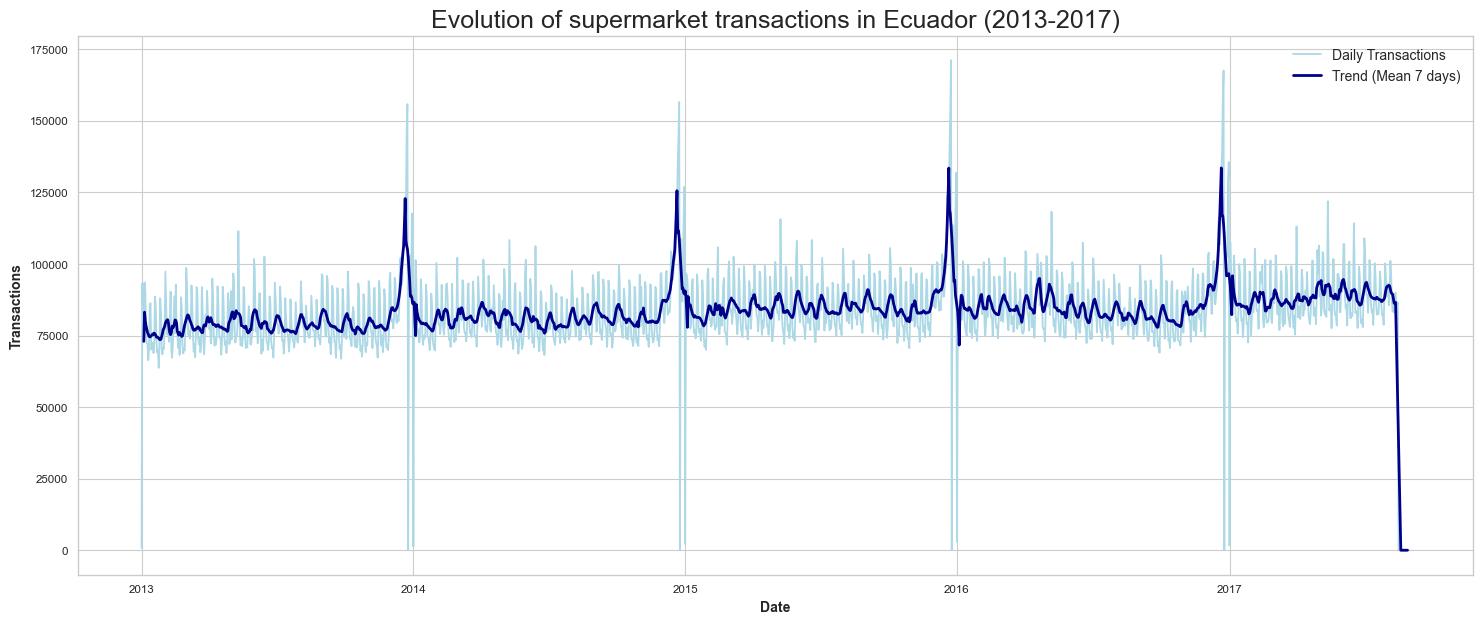

In [490]:
daily_total = transactions.groupby("date")["transactions"].sum().reset_index()
daily_total["rolling_7"] = daily_total["transactions"].rolling(window=7, center=True).mean()

plt.figure(figsize=(18, 7))

plt.plot(daily_total["date"], daily_total["transactions"], color='lightblue', label='Daily Transactions')
plt.plot(daily_total["date"], daily_total["rolling_7"], color='darkblue', linewidth=2, label='Trend (Mean 7 days)')

plt.title("Evolution of supermarket transactions in Ecuador (2013-2017)", fontsize=18)
plt.ylabel("Transactions")
plt.xlabel("Date")
plt.legend()

plt.show()

### Evolution of sales

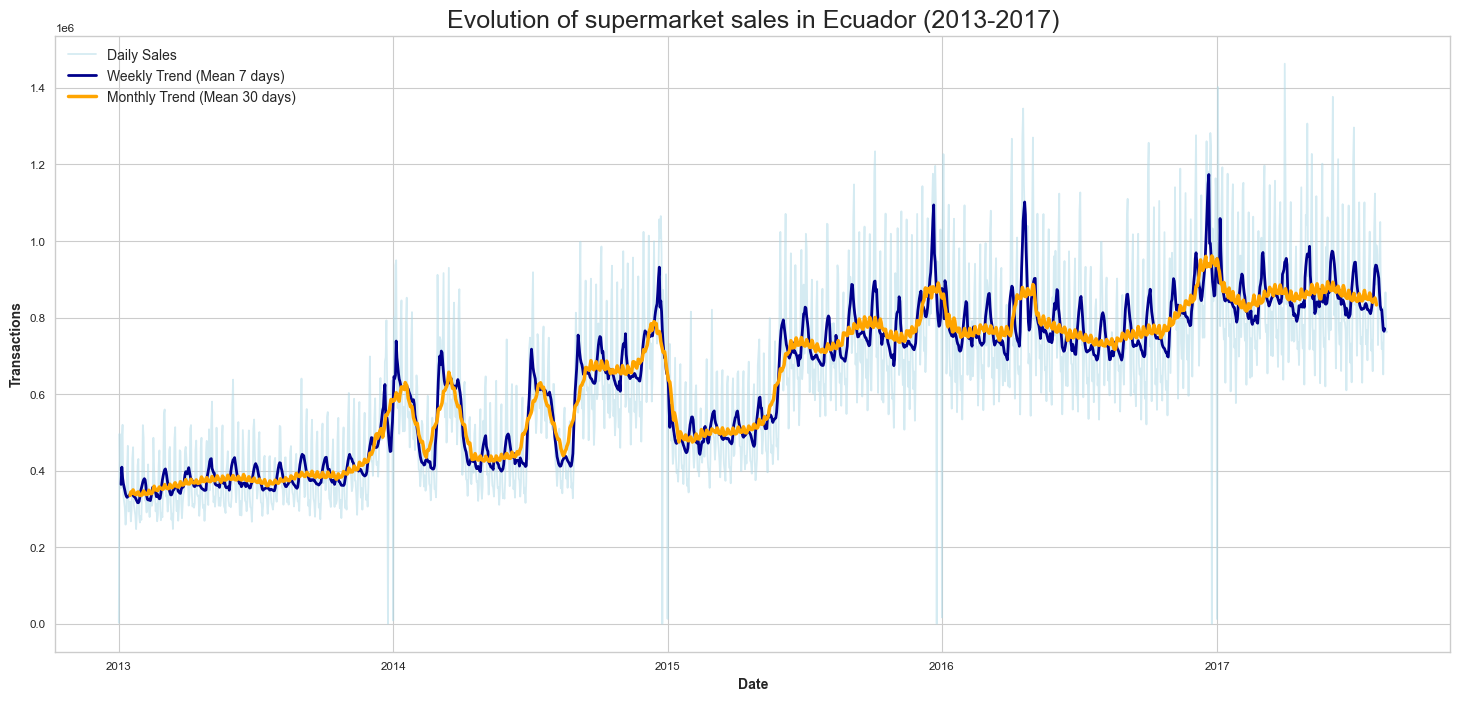

In [491]:
daily_sales = train.groupby("date")["sales"].sum().reset_index()
daily_sales["rolling_7"] = daily_sales["sales"].rolling(window=7, center=True).mean()
daily_sales["rolling_30"] = daily_sales["sales"].rolling(window=30, center=True).mean()

plt.figure(figsize=(18, 8))

plt.plot(daily_sales["date"], daily_sales["sales"], color='lightblue', alpha=0.5, label='Daily Sales')
plt.plot(daily_sales["date"], daily_sales["rolling_7"], color='darkblue', linewidth=2, label='Weekly Trend (Mean 7 days)')
plt.plot(daily_sales["date"], daily_sales["rolling_30"], color='orange', linewidth=2.5, label='Monthly Trend (Mean 30 days)')

plt.title("Evolution of supermarket sales in Ecuador (2013-2017)", fontsize=18)
plt.ylabel("Transactions")
plt.xlabel("Date")
plt.legend()

plt.show()

### Evolution of sales vs transactions

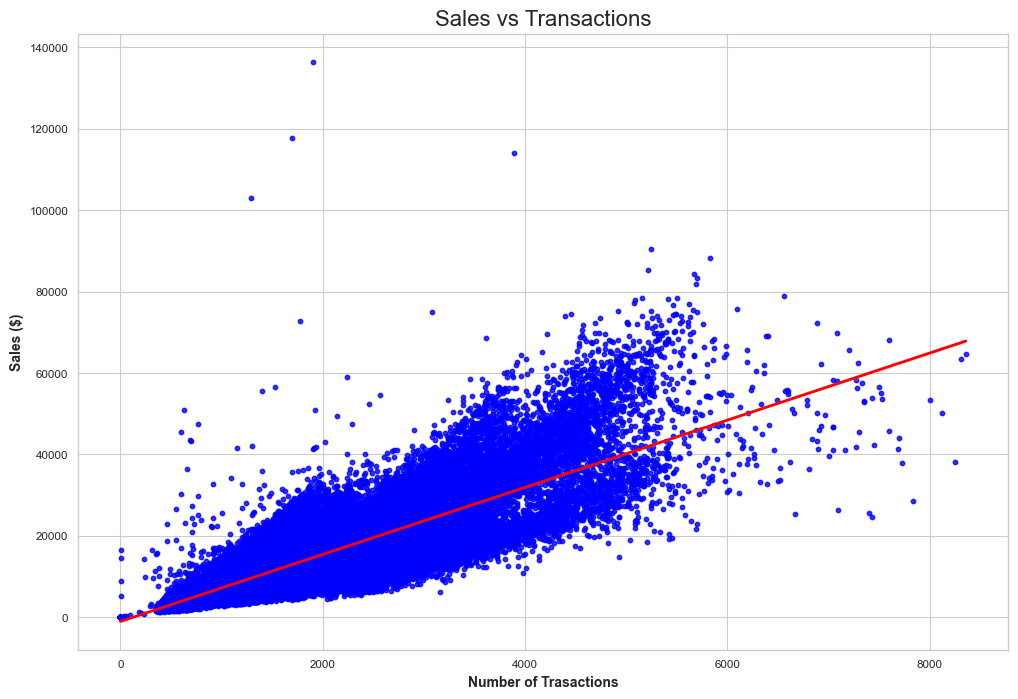

In [492]:
df_scatter = train.groupby(["date", "store_nbr"])["sales"].sum().reset_index().merge(transactions, on=["date", "store_nbr"], how="inner")

plt.figure(figsize=(12, 8))

sns.regplot( data=df_scatter, x="transactions", y="sales", scatter_kws={'s': 10, 'color': 'blue'}, line_kws={'color': 'red', 'linewidth': 2})

plt.title("Sales vs Transactions", fontsize=16)
plt.xlabel("Number of Trasactions")
plt.ylabel("Sales ($)")

plt.show()

### Sales by day of week

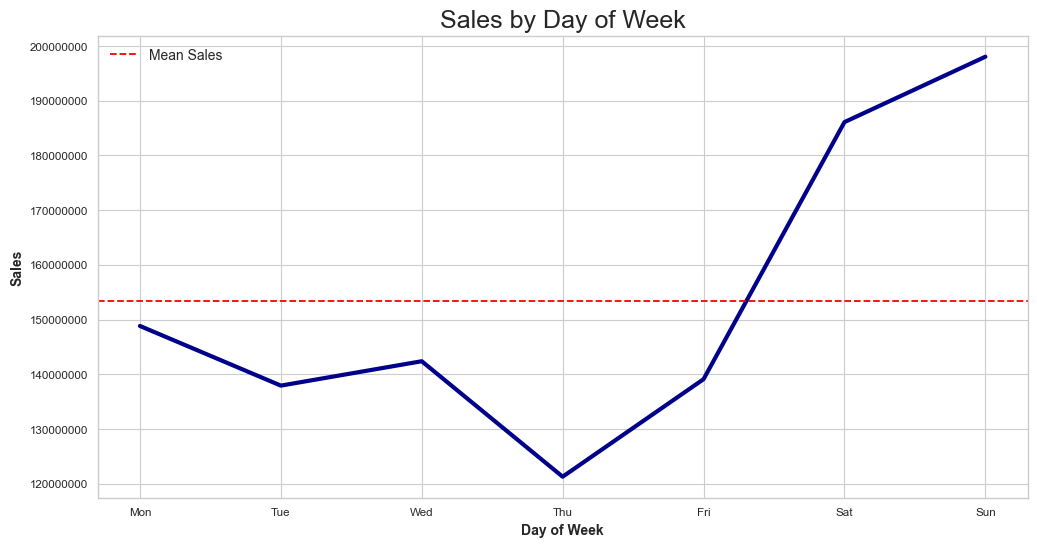

In [493]:
week_day_sales = train.groupby("day_of_week")["sales"].sum().reset_index()
mean_sales = week_day_sales["sales"].mean()

plt.figure(figsize=(12, 6))

plt.plot(week_day_sales["day_of_week"], week_day_sales["sales"], color='darkblue', linewidth=3)
plt.axhline(week_day_sales["sales"].mean(), color='red', linestyle='--', label='Mean Sales')

plt.title("Sales by Day of Week", fontsize=18)
plt.xlabel("Day of Week")
plt.ylabel("Sales")
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

plt.show()

### Sales by month

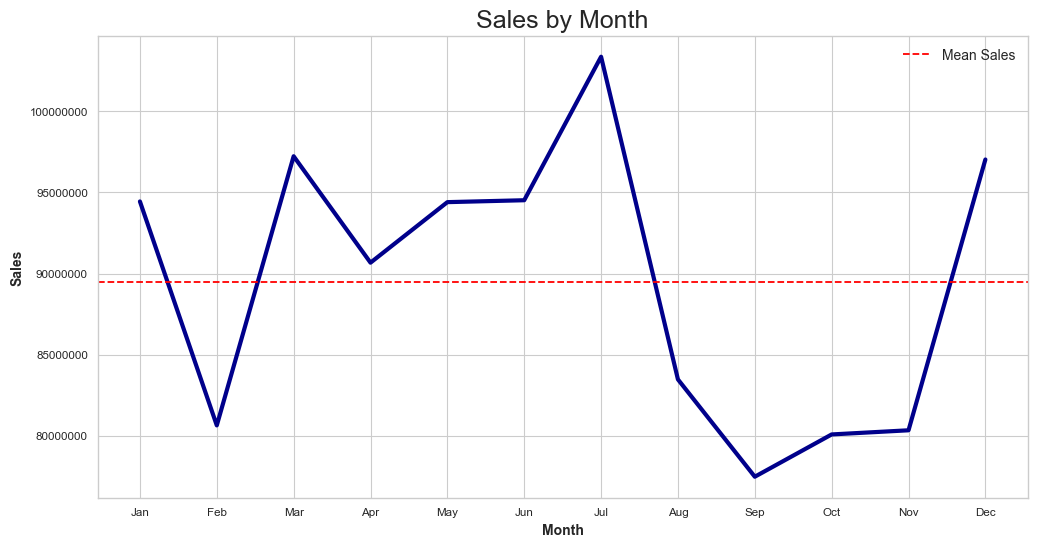

In [494]:
month_sales = train.groupby("month")["sales"].sum().reset_index()

plt.figure(figsize=(12, 6))

plt.plot(month_sales["month"], month_sales["sales"], color='darkblue', linewidth=3)
plt.axhline(month_sales["sales"].mean(), color='red', linestyle='--', label="Mean Sales",)

plt.title("Sales by Month", fontsize=18)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

plt.show()

### SALES BY FAMILY

### Evolution of oil price

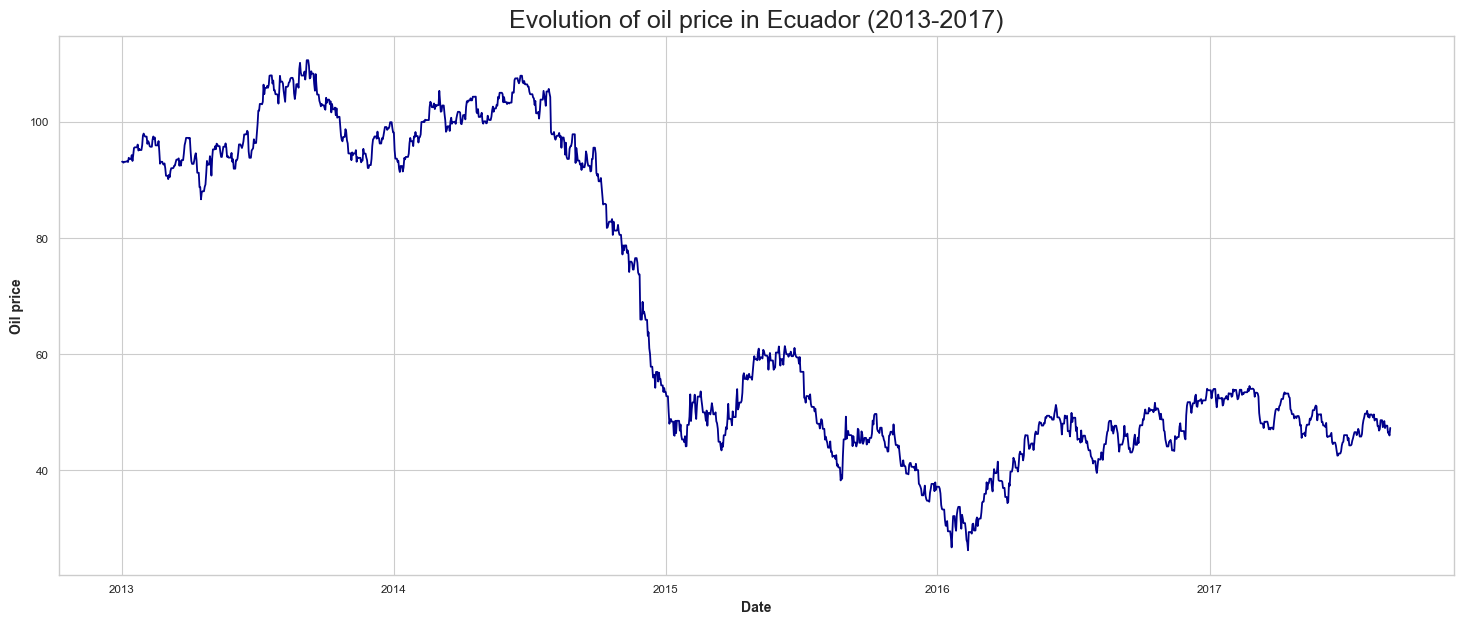

In [495]:
plt.figure(figsize=(18, 7))

plt.plot(oil["date"], oil["dcoilwtico"], color='darkblue')

plt.title("Evolution of oil price in Ecuador (2013-2017)", fontsize=18)
plt.ylabel("Oil price")
plt.xlabel("Date")

plt.show()

### OIL X SALES/TRANSACTIONS

### HOLIDAYS X SALES/TRANSACTIONS

## Model Development and Training

In [496]:
# Dividing data for models and cleaning useless and nan records 
# first year data will be deleted intentionally due to the use of lags
X_train  = train.drop(['sales', 'sales_lg', 'date', 'transactions'], axis=1).dropna()
y_train  = train['sales_lg']

X_test = test.drop(['sales', 'sales_lg', 'date', 'transactions'], axis=1)

cols_to_convert = [c for c in X_train.select_dtypes(include=['object']).columns if c in X_train.columns]

# Conversión Mágica
for col in cols_to_convert:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

## Conclusions and Insights